In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_percentage_error,
    mean_absolute_error,
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge

from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.trend import PolynomialTrendForecaster, TrendForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from sktime.forecasting.compose import TransformedTargetForecaster, ForecastingPipeline
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.trend import ProphetPiecewiseLinearTrendForecaster
from sktime.forecasting.compose import make_reduction
from sktime.split import ExpandingGreedySplitter

from hyperopt import fmin, hp, tpe
from hyperopt import SparkTrials, STATUS_OK, Trials
from scipy.optimize import minimize

import warnings

from sktime.forecasting.compose import EnsembleForecaster

In [2]:
data = pd.read_csv(
    "../../data/monthly/ewz_stromabgabe_netzebenen_stadt_zuerich.csv", index_col=None
)

data.index = pd.to_datetime(data["Timestamp"], utc=True)
data.index = data.index.tz_localize(None)
data["y"] = data["NE7_GWh"].values
data = data.drop(columns=["Timestamp", "NE5_GWh", "NE7_GWh"])
data.index = pd.period_range(start=data.index[0], end=data.index[-1], freq="M")

# split data
# don't use stride it keeps the last splitt completely unseen.
splitter = ExpandingGreedySplitter(test_size=12, folds=4)  # step_length=5 (stride),
splits = list(splitter.split(data))

In [3]:
# Let's add hyperparameter tuning for simple forecasters
def hyperParameterTuningSimpleForecaster(
    forecaster, search_space, data, splits, max_evals=30, timeout=5 * 60
):
    "Wrapper around hyperparameter tuning of any forecaster."

    def set_forecaster(forecaster):
        def train(params):
            """
            Main training function. Here we train the simple models and later
            select the ones which perform best over all splits.
            """
            f = forecaster(**params)
            metrics = []

            for split in splits[:-1]:
                y_train = data.iloc[split[0]]
                y_test = data.iloc[split[1]]
                idx = pd.period_range(
                    start=y_test.index[0], end=y_test.index[-1], freq="M"
                )
                prediction = f.fit_predict(
                    y_train, fh=ForecastingHorizon(idx, is_relative=False)
                )
                metrics.append(mean_absolute_error(y_test, prediction))
            return {"loss": np.median(metrics), "status": STATUS_OK, "Trained_Model": f}

        return train

    train_forecaster = set_forecaster(forecaster)
    algorithm = tpe.suggest  # Tree of Parzen Estimators, a Bayesian method
    hyperTrials = Trials()
    hyperparameters = fmin(
        fn=train_forecaster,
        space=search_space,
        algo=algorithm,
        trials=hyperTrials,
        max_evals=max_evals,
        timeout=timeout,  # seconds
    )
    bestModel = hyperTrials.results[
        np.argmin([r["loss"] for r in hyperTrials.results])
    ]["Trained_Model"]
    # is the model which has the lowest median error over all splits
    return bestModel

In [4]:
warnings.filterwarnings("ignore")

prophet_search_space = {
    "seasonality_mode": hp.choice("seasonality_mode", ["multiplicative", "additive"]),
    # optional according to docs, default = 0.8
    "changepoint_range": hp.uniform("changepoint_range", 0.8, 0.95),
    # according to recom. same as [0.001,0.5]
    "changepoint_prior_scale": hp.loguniform("changepoint_prior_scale", -6.9, -0.69),
    # according to recom. same as [0.001, 10]
    "seasonality_prior_scale": hp.loguniform("seasonality_prior_scale", -6.9, 2.3),
    # according to recom. same as [0.001, 10]
    # "holidays_prior_scale": hp.loguniform("holidays_prior_scale", -6.9, 2.3),
    # "add_country_holidays": hp.choice("holidays",[None,{'country_name': 'Switzerland'}]),
}

exp_search_space = {
    "trend": hp.choice("trend", ["additive", "multiplicative", None]),
    "seasonal": hp.choice("seasonal", ["additive", "multiplicative", None]),
    "sp": 12,
}

theta_search_space = {
    "deseasonalize": hp.choice("deseasonalize", [True, False]),
    "sp": 12,
}

simple_forecasters = {
    "prophet": [Prophet, prophet_search_space],
    "theta": [ThetaForecaster, theta_search_space],
    "exp": [ExponentialSmoothing, exp_search_space],
}

In [5]:
# tune hyperparams of simple models
simple_models = {}
for name, f_or_space in simple_forecasters.items():
    simple_models[name] = hyperParameterTuningSimpleForecaster(
        f_or_space[0], f_or_space[1], data, splits, max_evals=5
    )

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

17:22:44 - cmdstanpy - INFO - Chain [1] start processing

17:22:44 - cmdstanpy - INFO - Chain [1] done processing

17:22:44 - cmdstanpy - INFO - Chain [1] start processing

17:22:44 - cmdstanpy - INFO - Chain [1] done processing

17:22:44 - cmdstanpy - INFO - Chain [1] start processing

17:22:45 - cmdstanpy - INFO - Chain [1] done processing



 20%|██        | 1/5 [00:01<00:05,  1.50s/trial, best loss: 3.9792362151013685]

17:22:45 - cmdstanpy - INFO - Chain [1] start processing

17:22:45 - cmdstanpy - INFO - Chain [1] done processing

17:22:45 - cmdstanpy - INFO - Chain [1] start processing

17:22:45 - cmdstanpy - INFO - Chain [1] done processing

17:22:46 - cmdstanpy - INFO - Chain [1] start processing

17:22:46 - cmdstanpy - INFO - Chain [1] done processing



 40%|████      | 2/5 [00:02<00:03,  1.21s/trial, best loss: 3.9792362151013685]

17:22:46 - cmdstanpy - INFO - Chain [1] start processing

17:22:46 - cmdstanpy - INFO - Chain [1] done processing

17:22:46 - cmdstanpy - INFO - Chain [1] start processing

17:22:47 - cmdstanpy - INFO - Chain [1] done processing

17:22:47 - cmdstanpy - INFO - Chain [1] start processing

17:22:48 - cmdstanpy - INFO - Chain [1] done processing



 60%|██████    | 3/5 [00:04<00:03,  1.63s/trial, best loss: 3.9792362151013685]

17:22:48 - cmdstanpy - INFO - Chain [1] start processing

17:22:48 - cmdstanpy - INFO - Chain [1] done processing

17:22:49 - cmdstanpy - INFO - Chain [1] start processing

17:22:49 - cmdstanpy - INFO - Chain [1] done processing

17:22:49 - cmdstanpy - INFO - Chain [1] start processing

17:22:49 - cmdstanpy - INFO - Chain [1] done processing



 80%|████████  | 4/5 [00:05<00:01,  1.48s/trial, best loss: 3.9684064842301745]

17:22:49 - cmdstanpy - INFO - Chain [1] start processing

17:22:50 - cmdstanpy - INFO - Chain [1] done processing

17:22:50 - cmdstanpy - INFO - Chain [1] start processing

17:22:50 - cmdstanpy - INFO - Chain [1] done processing

17:22:50 - cmdstanpy - INFO - Chain [1] start processing

17:22:51 - cmdstanpy - INFO - Chain [1] done processing



100%|██████████| 5/5 [00:00<00:00,  7.12trial/s, best loss: 4.428976004919368]


In [6]:
# define a few composite forecasters
arima = TransformedTargetForecaster(
    [
        ("detrend", Detrender(forecaster=ProphetPiecewiseLinearTrendForecaster())),
        ("deseasonalize", Deseasonalizer(model="additive", sp=12)),
        ("forecast", ARIMA()),
    ]
)

random_forest = TransformedTargetForecaster(
    [
        ("detrend", Detrender(forecaster=ProphetPiecewiseLinearTrendForecaster())),
        (
            "forecast",
            make_reduction(
                RandomForestRegressor(), window_length=12, strategy="recursive"
            ),
        ),
    ]
)

In [20]:
forecasters = [
    ("composed arima", arima),
    ("composed forest", random_forest),
    ("prophet", simple_models["prophet"]),
    ("theta", simple_models["theta"]),
    ("exp", simple_models["exp"]),
]
ensemble = EnsembleForecaster(forecasters=forecasters, aggfunc="mean")

y_train = data.iloc[splits[-1][0]]
y_test = data.iloc[splits[-1][1]]

ensemble.fit(y=y_train)

17:30:32 - cmdstanpy - INFO - Chain [1] start processing

17:30:32 - cmdstanpy - INFO - Chain [1] done processing

17:30:33 - cmdstanpy - INFO - Chain [1] start processing

17:30:33 - cmdstanpy - INFO - Chain [1] done processing

17:30:33 - cmdstanpy - INFO - Chain [1] start processing

17:30:33 - cmdstanpy - INFO - Chain [1] done processing



EnsembleForecaster(forecasters=[('composed arima',
                                 TransformedTargetForecaster(steps=[('detrend',
                                                                     Detrender(forecaster=ProphetPiecewiseLinearTrendForecaster())),
                                                                    ('deseasonalize',
                                                                     Deseasonalizer(sp=12)),
                                                                    ('forecast',
                                                                     ARIMA())])),
                                ('composed forest',
                                 TransformedTargetForecaster(steps=[('detrend',
                                                                     Detrender(forecaster=ProphetPiecewiseLinearTrendForecaster())),
                                                                    (...
                                                                     RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                                                                                          window_length=12))])),
                                ('prophet',
                                 Prophet(changepoint_prior_scale=0.0011402918091715382,
                                         changepoint_range=0.8157513598047099,
                                         seasonality_mode='multiplicative',
                                         seasonality_prior_scale=1.1558237182181066)),
                                ('theta', ThetaForecaster(sp=12)),
                                ('exp',
                                 ExponentialSmoothing(seasonal='additive',
                                                      sp=12,
                                                      trend='additive'))])

In [21]:
idx = pd.period_range(start=y_test.index[0], end=y_test.index[-1], freq="M")
horizon = ForecastingHorizon(idx, is_relative=False)
y_pred = ensemble.predict(fh=horizon)

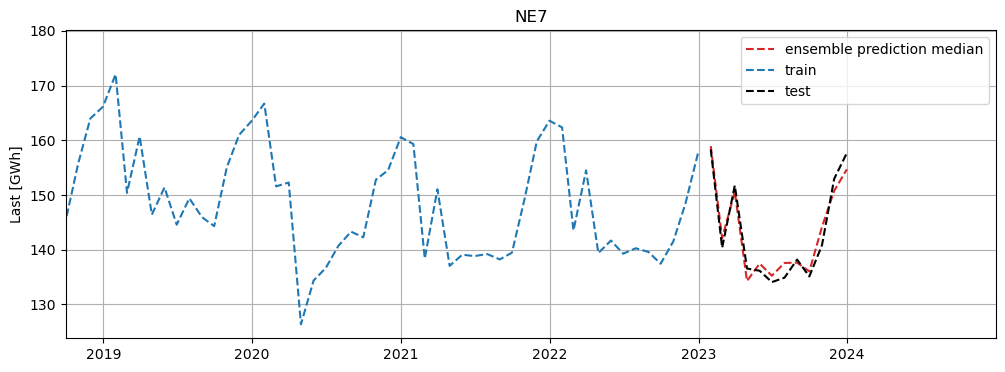

In [22]:
f, axes = plt.subplots(1, 1, figsize=(12, 4))

axes.plot(
    y_pred.index.to_timestamp(freq="M"),
    y_pred.values,
    label="ensemble prediction median",
    color="tab:red",
    linestyle="--",
)

axes.plot(
    y_train.index.to_timestamp(freq="M"),
    y_train.values,
    label="train",
    color="tab:blue",
    linestyle="--",
)

axes.plot(
    y_test.index.to_timestamp(freq="M"),
    y_test.values,
    label="test",
    color="black",
    linestyle="--",
)

axes.legend()
axes.set_title("NE7")
axes.set_ylabel("Last [GWh]")

axes.set_xlim([pd.Timestamp(2018, 10, 1), pd.Timestamp(2024, 12, 31)])
axes.grid()
plt.show()

In [23]:
ensemble.score(y_test)

# median 0.01274327898644322
# mean 0.012223586474388795

0.012223586474388795